# 测试集图像语义特征可视化


1. 计算测试集图像的语义特征
2. 使用t-SNE算法进行降维可视化
3. 使用UMAP算法进行降维可视化



## 一、计算测试集图像的语义特征


### 1.导入训练好的模型

In [1]:
from tqdm import tqdm
import pandas as pd
import numpy as np
import torch
import cv2
from PIL import Image
from torchvision import transforms
# 忽略烦人的红色提示
import warnings
warnings.filterwarnings("ignore")
# 有 GPU 就用 GPU，没有就用 CPU
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print('device', device)
# 测试集图像预处理-RCTN：缩放、裁剪、转 Tensor、归一化
test_transform = transforms.Compose([transforms.Resize(256),
                                     transforms.CenterCrop(224),
                                     transforms.ToTensor(),
                                     transforms.Normalize(
                                         mean=[0.485, 0.456, 0.406], 
                                         std=[0.229, 0.224, 0.225])
                                    ])

#导入训练好的模型
model = torch.load('D:\SanYeQing_Project\wht_sanyeqing_image-Classification\model_zheng_path\model_cpu_97.18.pth')
model = model.eval().to(device)


device cpu


### 2.抽取模型中间层输出结果作为语义特征

In [5]:
#查看模型架构并保存
from torchvision.models.feature_extraction import create_feature_extractor
with open('model.txt', 'w') as f:
    print(model, file=f)
print(model)
#提取avgpool层的输出
model_trunc = create_feature_extractor(model, return_nodes={'avgpool': 'semantic_feature'})


MobileNetV3(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
      (2): Hardswish()
    )
    (1): InvertedResidual(
      (block): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=16, bias=False)
          (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
          (2): ReLU(inplace=True)
        )
        (1): Conv2dNormActivation(
          (0): Conv2d(16, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
        )
      )
    )
    (2): InvertedResidual(
      (block): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(16, 64, kernel_size=(1, 1), stride=(1, 1), bi

### 3.计算单张图像的语义特征

In [6]:
img_path = "D:\微信图片_20240610010543.png"
img_pil = Image.open(img_path)
if img_pil.mode != "RGB":
        img_pil = img_pil.convert("RGB")
input_img = test_transform(img_pil) # 预处理
input_img = input_img.unsqueeze(0).to(device)
# 执行前向预测，得到指定中间层的输出
pred_logits = model_trunc(input_img) 

print(pred_logits['semantic_feature'].squeeze().detach().cpu().numpy().shape)
print(pred_logits['semantic_feature'].squeeze().detach().cpu().numpy())

(960,)
[ 6.46759421e-02  1.05904102e-01  3.18340212e-01  1.05756164e-01
 -4.49069552e-02 -1.05709739e-01  3.99057746e-01 -2.20372960e-01
  9.32675719e-01  9.13406849e-01 -5.46067208e-02 -1.39799446e-01
  2.34816652e-02  6.69582635e-02 -2.10905783e-02  1.73280403e-01
 -1.89452946e-01  4.85383898e-01  1.91254184e-01 -1.11771159e-01
 -1.39386043e-01  4.30945188e-01 -7.47005343e-02 -9.80612114e-02
 -1.19597375e-01  7.05818594e-01  1.24053277e-01 -1.79246530e-01
  3.51956010e-01  8.30817446e-02  3.57701778e-01  1.77027822e-01
 -2.04227641e-01  7.88453758e-01 -1.20624922e-01  8.72253478e-01
  4.03262496e-01 -1.74922422e-01  1.41422713e+00 -7.39359781e-02
  2.82000452e-02 -5.24720512e-02 -2.83598583e-02 -8.49733353e-02
  9.36621577e-02 -9.40499306e-02  8.72716978e-02  4.98191535e-01
  4.64121670e-01  3.09904907e-02  2.21748561e-01 -6.81294650e-02
 -1.63278878e-01  1.36584774e-01 -6.10368103e-02  6.43998563e-01
  6.53021410e-02 -1.51588812e-01  8.22027493e-03  7.90330470e-01
  4.32646304e-01  

### 4.得到所有测试集图像的语义特征

In [7]:
#导入测试集预测结果
df = pd.read_csv('测试集预测结果.csv')
print(df.head())

#计算测试集每张图像的语义特征
encoding_array = []
img_path_list = []

for img_path in tqdm(df['img_path']):
    img_path_list.append(img_path)
    img_pil = Image.open(img_path).convert('RGB')
    input_img = test_transform(img_pil).unsqueeze(0).to(device) # 预处理
    feature = model_trunc(input_img)['semantic_feature'].squeeze().detach().cpu().numpy() # 执行前向预测，得到 avgpool 层输出的语义特征
    encoding_array.append(feature)
encoding_array = np.array(encoding_array)


print(encoding_array.shape)
# 保存为本地的 npy 文件
np.save('测试集语义特征.npy', encoding_array)

# # 转换为DataFrame
# df = pd.DataFrame(encoding_array)
# # 保存为CSV文件
# df.to_csv('data.csv', index=False)

                                            img_path true_class  top_n预测正确  \
0  D:\SanYeQing_Project\sanyeqing_hun_weizhi_fina...        云南省          1   
1  D:\SanYeQing_Project\sanyeqing_hun_weizhi_fina...         未知          1   
2  D:\SanYeQing_Project\sanyeqing_hun_weizhi_fina...         未知          1   
3  D:\SanYeQing_Project\sanyeqing_hun_weizhi_fina...         未知          1   
4  D:\SanYeQing_Project\sanyeqing_hun_weizhi_fina...         未知          1   

  top-1-predicted-class  top-1-probs top-2-predicted-class  top-2-probs  \
0                   云南省      0.96628                   广西省      0.03097   
1                    未知      1.00000                   云南省      0.00000   
2                    未知      1.00000                   云南省      0.00000   
3                    未知      1.00000                   云南省      0.00000   
4                    未知      0.96488                   广西省      0.02709   

  top-3-predicted-class  top-3-probs  class_云南省_prob  class_广西省_prob  \
0       

100%|██████████| 1842/1842 [02:01<00:00, 15.16it/s]

(1842, 960)


### 5.查看npy文件

In [8]:
import numpy as np
# 加载.npy文件
data = np.load('测试集语义特征.npy')
# 打印数组
print(data)
print('Shape:', data.shape)
print('Size:', data.size)
print('Data type:', data.dtype)


[[ 0.04797193  0.5343219  -0.14616594 ...  0.18760136  0.08469063
  -0.21101218]
 [ 0.91120005  0.30567458 -0.12180017 ... -0.1474964   0.05857769
   0.19541042]
 [ 0.9797515   0.03893668  0.09883203 ... -0.06303377  0.26093683
   0.07680568]
 ...
 [ 0.3946745   0.09074088  0.48224896 ... -0.10442776 -0.11314836
  -0.04554338]
 [ 0.6893072   0.10688651  0.8023414  ... -0.27061915  0.04857814
   0.06230904]
 [ 0.2607295  -0.14744045 -0.05238758 ... -0.15571511  0.45510685
   0.28407103]]
Shape: (1842, 960)
Size: 1768320
Data type: float32


## 二、使用t-SNE算法进行降维可视化

### 1. 设置中文字体

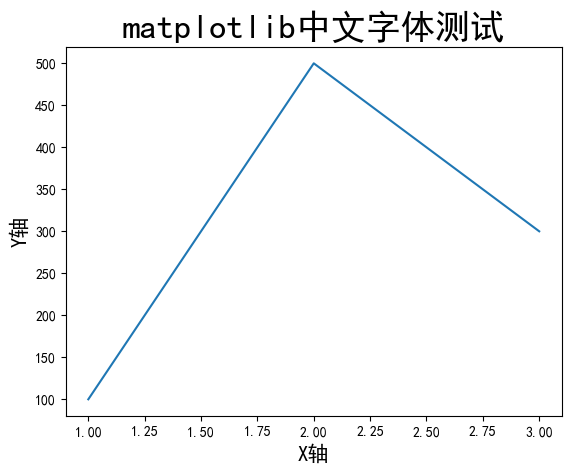

In [6]:
#设置中文字体
import matplotlib.pyplot as plt
%matplotlib inline
# # windows操作系统
plt.rcParams['font.sans-serif']=['SimHei']  # 用来正常显示中文标签 
plt.rcParams['axes.unicode_minus']=False  # 用来正常显示负号
plt.plot([1,2,3], [100,500,300])
plt.title('matplotlib中文字体测试', fontsize=25)
plt.xlabel('X轴', fontsize=15)
plt.ylabel('Y轴', fontsize=15)
plt.show()

### 2.载入数据

In [2]:
import numpy as np
import pandas as pd
import cv2
#载入测试集语义特征
encoding_array = np.load('测试集语义特征.npy', allow_pickle=True)
print(encoding_array.shape)
#载入测试集预测结果
df = pd.read_csv('测试集预测结果.csv')
print(df.head())
classes = df['true_class'].unique()
print(classes)

(1842, 960)
                                            img_path true_class  top_n预测正确  \
0  D:\SanYeQing_Project\sanyeqing_hun_weizhi_fina...        云南省          1   
1  D:\SanYeQing_Project\sanyeqing_hun_weizhi_fina...         未知          1   
2  D:\SanYeQing_Project\sanyeqing_hun_weizhi_fina...         未知          1   
3  D:\SanYeQing_Project\sanyeqing_hun_weizhi_fina...         未知          1   
4  D:\SanYeQing_Project\sanyeqing_hun_weizhi_fina...         未知          1   

  top-1-predicted-class  top-1-probs top-2-predicted-class  top-2-probs  \
0                   云南省      0.96628                   广西省      0.03097   
1                    未知      1.00000                   云南省      0.00000   
2                    未知      1.00000                   云南省      0.00000   
3                    未知      1.00000                   云南省      0.00000   
4                    未知      0.96488                   广西省      0.02709   

  top-3-predicted-class  top-3-probs  class_云南省_prob  class_广西省_prob

### 3.可视化配置

['云南省' '广西省' '未知' '浙江省' '贵州省' '陕西省']


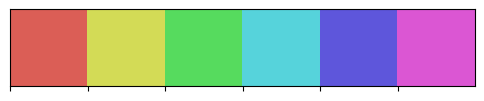

In [3]:
import seaborn as sns
marker_list = ['.', ',', 'o', 'v', '^', '<', '>', '1', '2', '3', '4', '8', 's', 'p', 'P', '*', 'h', 'H', '+', 'x', 'X', 'D', 'd', '|', '_', 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11]
class_list = np.unique(df['true_class'])
print(class_list)
n_class = len(class_list) # 测试集标签类别数
palette = sns.hls_palette(n_class) # 配色方案
sns.palplot(palette)
# 随机打乱颜色列表和点型列表
import random
random.seed(24)
random.shuffle(marker_list)
random.shuffle(palette)

### 4.t-SNE降维至二维并可视化

d:\SanYeQing_Project\wht_sanyeqing_image-Classification\.venv\Lib\site-packages\sklearn\manifold\_t_sne.py:1162: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


(1842, 2)


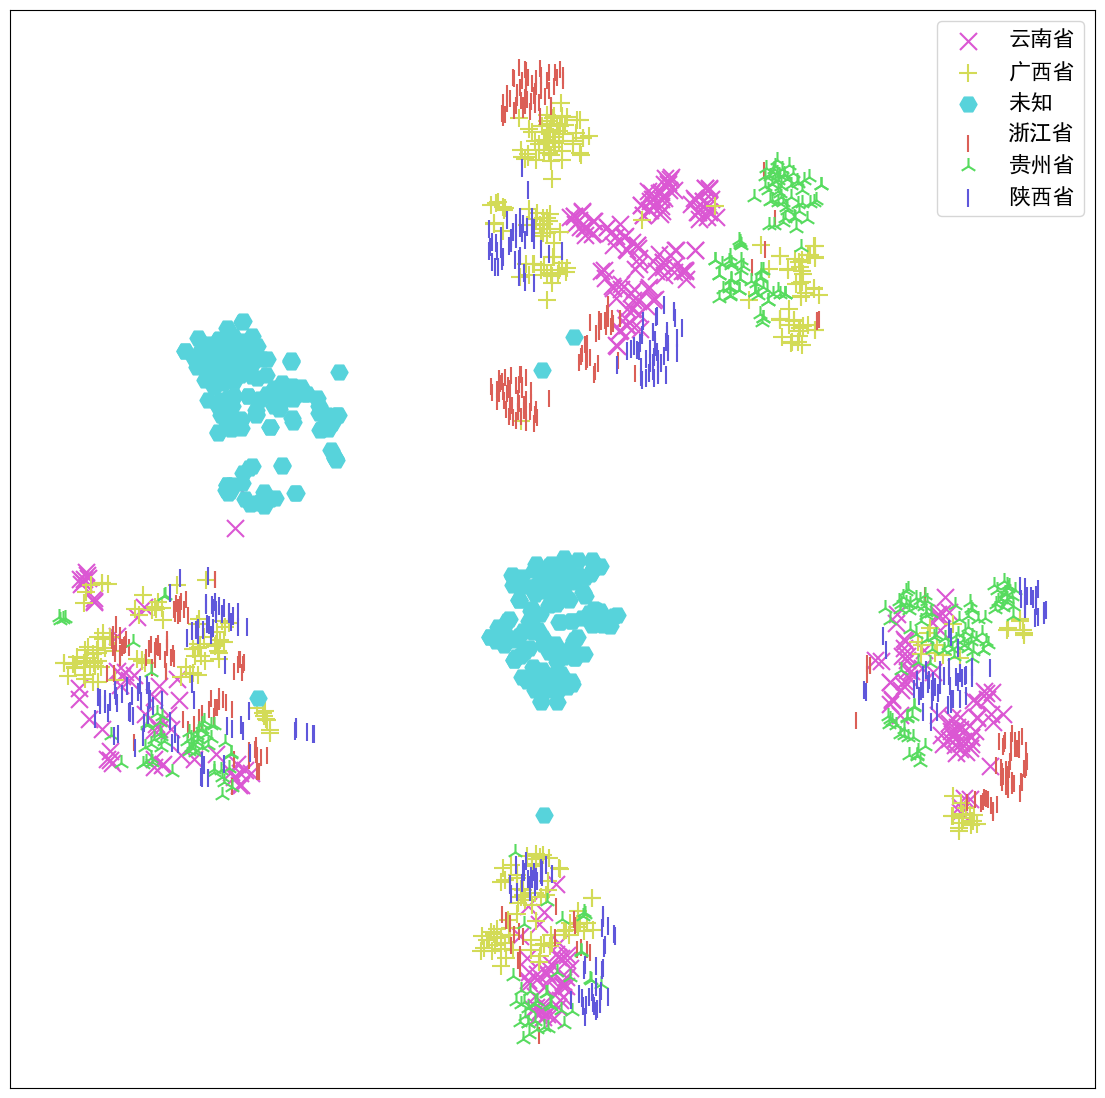

In [5]:
# 降维到二维和三维
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2, n_iter=20000)
X_tsne_2d = tsne.fit_transform(encoding_array)
print(X_tsne_2d.shape)

# 不同的 符号 表示 不同的 标注类别
show_feature = 'true_class'
plt.figure(figsize=(14, 14))
for idx, fruit in enumerate(class_list): # 遍历每个类别
    # 获取颜色和点型
    color = palette[idx]
    marker = marker_list[idx%len(marker_list)]

    # 找到所有标注类别为当前类别的图像索引号
    indices = np.where(df[show_feature]==fruit)
    plt.scatter(X_tsne_2d[indices, 0], X_tsne_2d[indices, 1], color=color, marker=marker, label=fruit, s=150)

plt.legend(fontsize=16, markerscale=1, bbox_to_anchor=(1, 1))
plt.xticks([])
plt.yticks([])
plt.savefig('语义特征t-SNE二维降维可视化.pdf', dpi=300) # 保存图像
plt.show()


### 5.plotply交互式可视化

In [6]:
import plotly.express as px
df_2d = pd.DataFrame()
df_2d['X'] = list(X_tsne_2d[:, 0].squeeze())
df_2d['Y'] = list(X_tsne_2d[:, 1].squeeze())
df_2d['true_class'] = df['true_class']
df_2d['预测类别'] = df['top-1-predicted-class']
df_2d['img_path'] = df['img_path']
df_2d.to_csv('t-SNE-2D.csv', index=False)
print(df_2d.head())


fig = px.scatter(df_2d, 
                 x='X', 
                 y='Y',
                 color=show_feature, 
                 labels=show_feature,
                 symbol=show_feature, 
                 hover_name='img_path',
                 opacity=0.8,
                 width=1000, 
                 height=600
                )
# 设置排版
fig.update_layout(margin=dict(l=0, r=0, b=0, t=0))
fig.show()
fig.write_html('语义特征t-SNE二维降维plotly可视化.html')


           X          Y true_class 预测类别  \
0  -4.694950 -62.846607        云南省  云南省   
1 -46.398460  27.659582         未知   未知   
2 -45.492485  27.050732         未知   未知   
3 -54.186054  32.754356         未知   未知   
4 -56.301189  11.868798         未知   未知   

                                            img_path  
0  D:\SanYeQing_Project\sanyeqing_hun_weizhi_fina...  
1  D:\SanYeQing_Project\sanyeqing_hun_weizhi_fina...  
2  D:\SanYeQing_Project\sanyeqing_hun_weizhi_fina...  
3  D:\SanYeQing_Project\sanyeqing_hun_weizhi_fina...  
4  D:\SanYeQing_Project\sanyeqing_hun_weizhi_fina...  


### 6.查看图像

(1, 15)


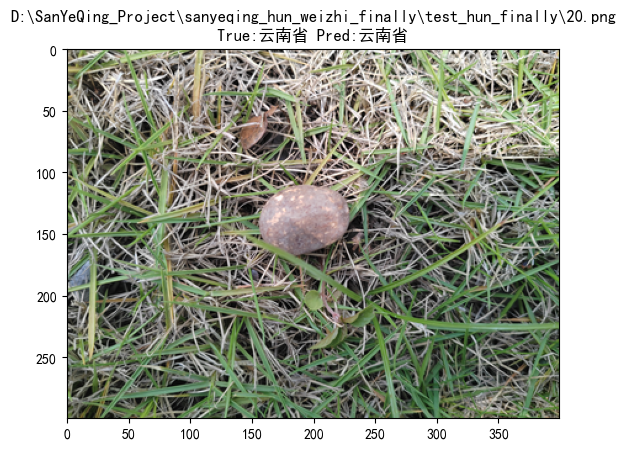

In [17]:
# 查看图像
img_path_temp = r"D:\SanYeQing_Project\sanyeqing_hun_weizhi_finally\test_hun_finally\20.png"

img_bgr = cv2.imread(img_path_temp)
img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
plt.imshow(img_rgb)
temp_df = df[df['img_path'] == img_path_temp]


print(temp_df.shape)

title_str = img_path_temp + '\nTrue:' + temp_df['true_class'].item() + ' Pred:' + temp_df['top-1-predicted-class'].item()
plt.title(title_str)
plt.show()

### 7.t-SNE降维至三维，并可视化

In [18]:
# 降维到三维
from sklearn.manifold import TSNE
tsne = TSNE(n_components=3, n_iter=10000)
X_tsne_3d = tsne.fit_transform(encoding_array)
print(X_tsne_3d.shape)


d:\SanYeQing_Project\wht_sanyeqing_image-Classification\.venv\Lib\site-packages\sklearn\manifold\_t_sne.py:1162: FutureWarning:

'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.



(1842, 3)


In [19]:
#t-SNE三维降维plotly可视化
show_feature = 'true_class'
df_3d = pd.DataFrame()
df_3d['X'] = list(X_tsne_3d[:, 0].squeeze())
df_3d['Y'] = list(X_tsne_3d[:, 1].squeeze())
df_3d['Z'] = list(X_tsne_3d[:, 2].squeeze())
df_3d['true_class'] = df['true_class']
df_3d['预测类别'] = df['top-1-predicted-class']
df_3d['img_path'] = df['img_path']
df_3d.to_csv('t-SNE-3D.csv', index=False)

fig = px.scatter_3d(df_3d, 
                    x='X', 
                    y='Y', 
                    z='Z',
                    color=show_feature, 
                    labels=show_feature,
                    symbol=show_feature, 
                    hover_name='img_path',
                    opacity=0.6,
                    width=1000, 
                    height=800)

# 设置排版
fig.update_layout(margin=dict(l=0, r=0, b=0, t=0))
fig.show()
fig.write_html('语义特征t-SNE三维降维plotly可视化.html')

## 三、使用UMAP算法进行降维可视化

In [20]:
#安装
!pip install umap-learn datashader bokeh holoviews scikit-image colorcet

   ---------------------------------------- 0.0/85.7 kB ? eta -:--:--
   ---- ----------------------------------- 10.2/85.7 kB ? eta -:--:--
   ---- ----------------------------------- 10.2/85.7 kB ? eta -:--:--
   ---------------------------- ----------- 61.4/85.7 kB 469.7 kB/s eta 0:00:01
   -------------------------------------- - 81.9/85.7 kB 512.0 kB/s eta 0:00:01
   ---------------------------------------- 85.7/85.7 kB 438.8 kB/s eta 0:00:00
   ---------------------------------------- 0.0/18.3 MB ? eta -:--:--
   ---------------------------------------- 0.0/18.3 MB ? eta -:--:--
   ---------------------------------------- 0.0/18.3 MB 653.6 kB/s eta 0:00:28
   ---------------------------------------- 0.1/18.3 MB 648.1 kB/s eta 0:00:29
   ---------------------------------------- 0.1/18.3 MB 558.5 kB/s eta 0:00:33
   ---------------------------------------- 0.1/18.3 MB 558.5 kB/s eta 0:00:33
   ---------------------------------------- 0.1/18.3 MB 490.2 kB/s eta 0:00:38
   ----------

### 1.UMAP降维至二维可视化

In [12]:
import umap
import umap.plot
mapper = umap.UMAP(n_neighbors=10, n_components=2, random_state=12).fit(encoding_array)
X_umap_2d = mapper.embedding_
print(X_umap_2d.shape)

d:\SanYeQing_Project\wht_sanyeqing_image-Classification\.venv\Lib\site-packages\umap\umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


(1842, 2)


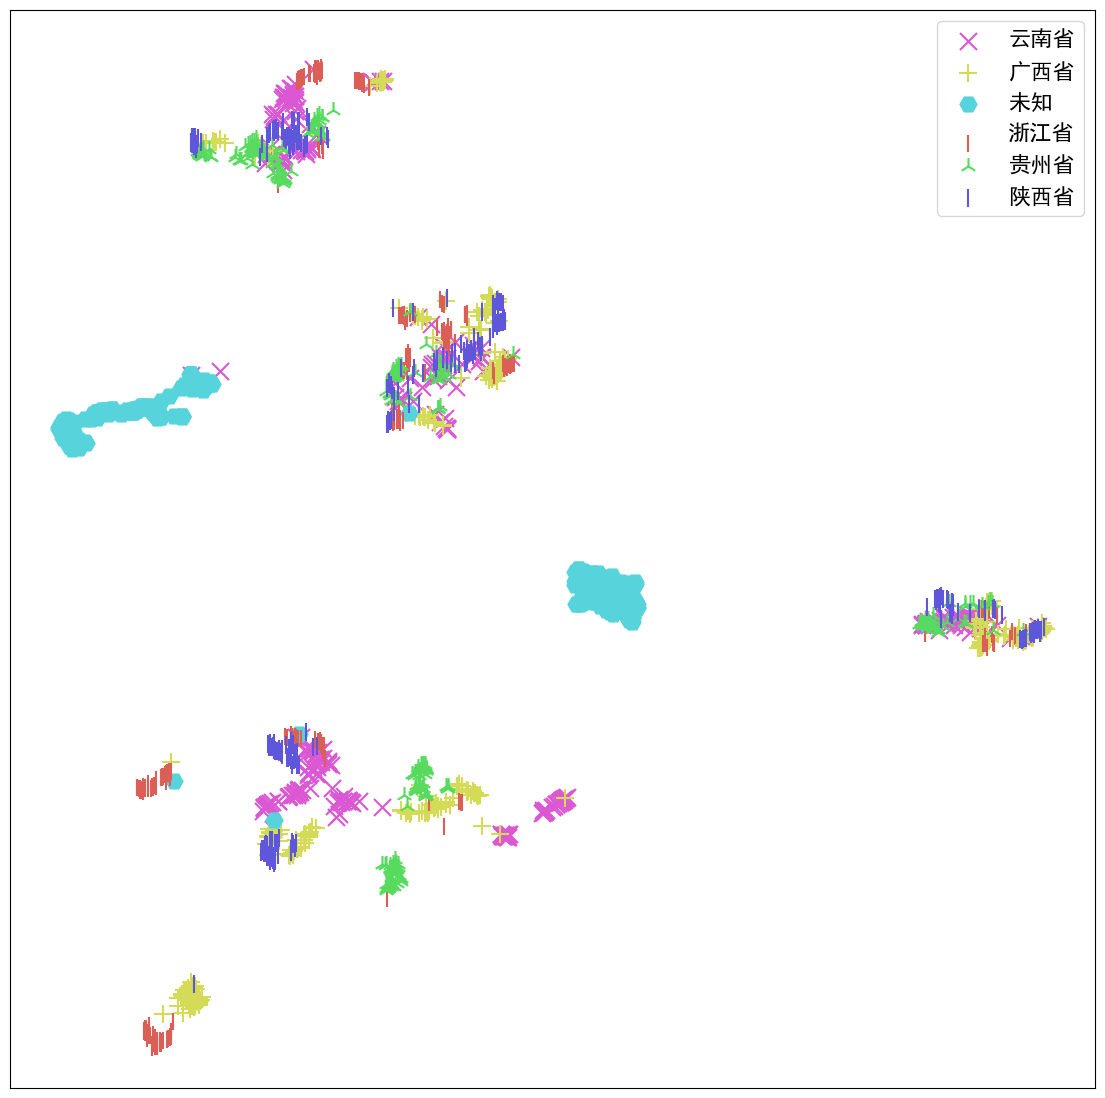

In [13]:
# 不同的 符号 表示 不同的 标注类别
show_feature = 'true_class'
plt.figure(figsize=(14, 14))
for idx, fruit in enumerate(class_list): # 遍历每个类别
    # 获取颜色和点型
    color = palette[idx]
    marker = marker_list[idx%len(marker_list)]

    # 找到所有标注类别为当前类别的图像索引号
    indices = np.where(df[show_feature]==fruit)
    plt.scatter(X_umap_2d[indices, 0], X_umap_2d[indices, 1], color=color, marker=marker, label=fruit, s=150)

plt.legend(fontsize=16, markerscale=1, bbox_to_anchor=(1, 1))
plt.xticks([])
plt.yticks([])
plt.savefig('语义特征UMAP二维降维可视化.pdf', dpi=300) # 保存图像
plt.show()


### 2.可视化新图像的语义特征

(1, 960)
[1.8300776 9.399532 ]


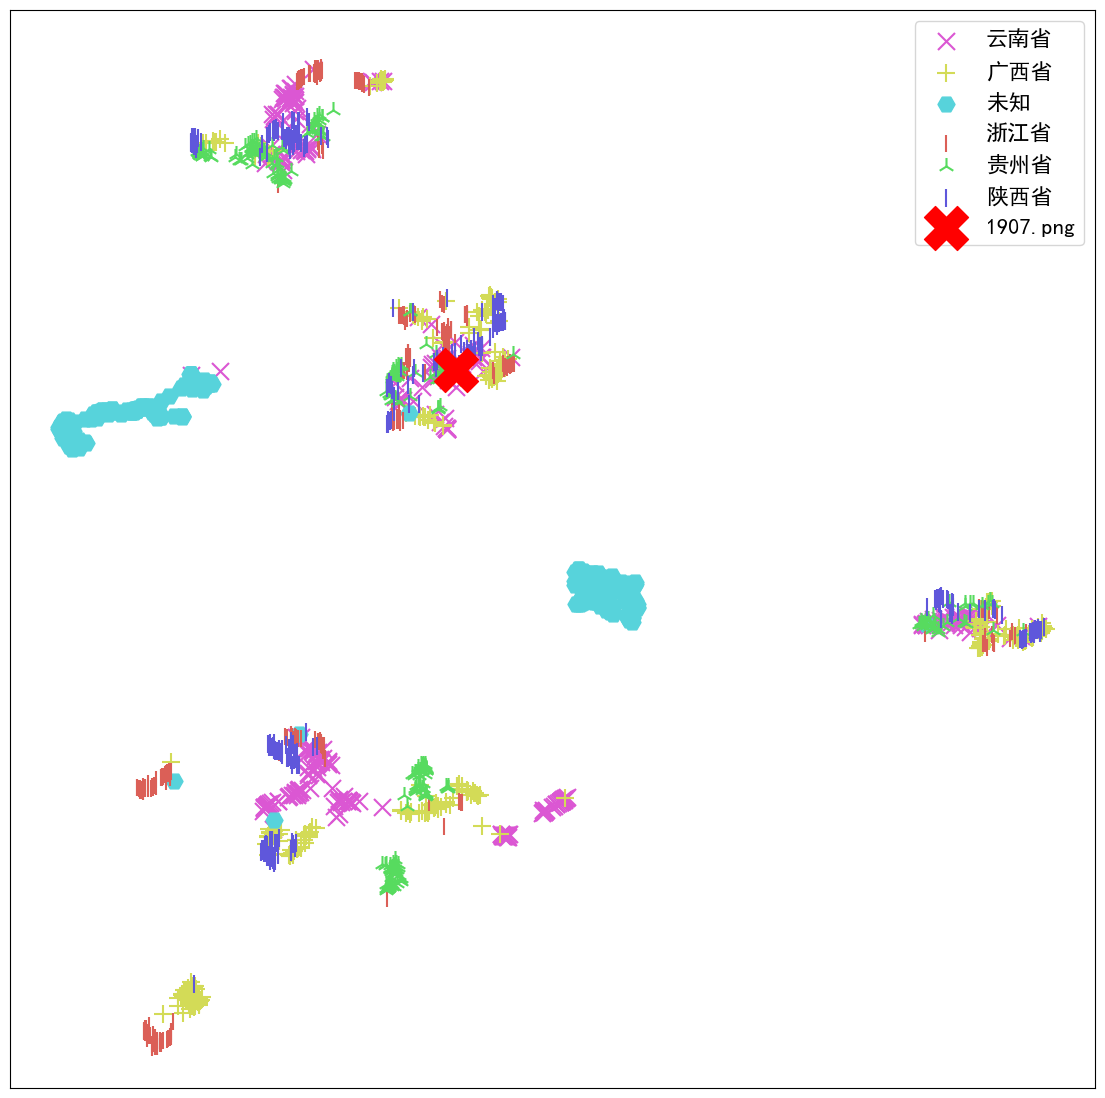

In [14]:
import cv2
import torch
from PIL import Image
from torchvision import transforms

# 有 GPU 就用 GPU，没有就用 CPU
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

model = torch.load(r'D:\SanYeQing_Project\wht_sanyeqing_image-Classification\model_zheng_path\model_cpu_97.18.pth')
model = model.eval().to(device)

from torchvision.models.feature_extraction import create_feature_extractor
model_trunc = create_feature_extractor(model, return_nodes={'avgpool': 'semantic_feature'})

# 测试集图像预处理-RCTN：缩放、裁剪、转 Tensor、归一化
test_transform = transforms.Compose([transforms.Resize(256),
                                     transforms.CenterCrop(224),
                                     transforms.ToTensor(),
                                     transforms.Normalize(
                                         mean=[0.485, 0.456, 0.406], 
                                         std=[0.229, 0.224, 0.225])
                                    ])

img_path = r'1907.png'
img_pil = Image.open(img_path)
input_img = test_transform(img_pil) # 预处理
input_img = input_img.unsqueeze(0).to(device)
# 执行前向预测，得到指定中间层的输出
pred_logits = model_trunc(input_img)
semantic_feature = pred_logits['semantic_feature'].squeeze().detach().cpu().numpy().reshape(1,-1)
print(semantic_feature.shape)

# umap降维
new_embedding = mapper.transform(semantic_feature)[0]
print(new_embedding)

plt.figure(figsize=(14, 14))
for idx, fruit in enumerate(class_list): # 遍历每个类别
    # 获取颜色和点型
    color = palette[idx]
    marker = marker_list[idx%len(marker_list)]

    # 找到所有标注类别为当前类别的图像索引号
    indices = np.where(df[show_feature]==fruit)
    plt.scatter(X_umap_2d[indices, 0], X_umap_2d[indices, 1], color=color, marker=marker, label=fruit, s=150)

plt.scatter(new_embedding[0], new_embedding[1], color='r', marker='X', label=img_path, s=1000)

plt.legend(fontsize=16, markerscale=1, bbox_to_anchor=(1, 1))
plt.xticks([])
plt.yticks([])
plt.savefig('语义特征UMAP二维降维可视化-新图像.pdf', dpi=300) # 保存图像
plt.show()


### 3.plotply交互式可视化

<class 'pandas.core.frame.DataFrame'>
              X         Y true_class  预测类别  \
0     13.781320  1.844272        云南省   云南省   
1     -4.962673  8.368999         未知    未知   
2     -4.913653  8.327182         未知    未知   
3     -6.313480  7.426819         未知    未知   
4     -3.888962  9.219365         未知    未知   
...         ...       ...        ...   ...   
1838  -5.817679  8.274680         未知    未知   
1839  -5.051082  8.265968         未知    未知   
1840  -6.365855  7.403152         未知    未知   
1841  -5.097655  8.246337         未知    未知   
1842   1.830078  9.399532   1907.png  None   

                                               img_path  
0     D:\SanYeQing_Project\sanyeqing_hun_weizhi_fina...  
1     D:\SanYeQing_Project\sanyeqing_hun_weizhi_fina...  
2     D:\SanYeQing_Project\sanyeqing_hun_weizhi_fina...  
3     D:\SanYeQing_Project\sanyeqing_hun_weizhi_fina...  
4     D:\SanYeQing_Project\sanyeqing_hun_weizhi_fina...  
...                                                 ...  
183

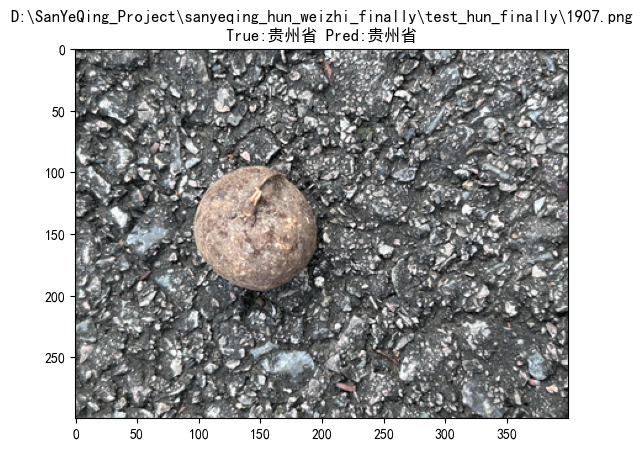

In [30]:
import plotly.express as px
df_2d = pd.DataFrame()
df_2d['X'] = list(X_umap_2d[:, 0].squeeze())
df_2d['Y'] = list(X_umap_2d[:, 1].squeeze())
df_2d['true_class'] = df['true_class']
df_2d['预测类别'] = df['top-1-predicted-class']
df_2d['img_path'] = df['img_path']
df_2d.to_csv('UMAP-2D.csv', index=False)
print(type(df_2d))
# 增加新图像的一行
new_img_row = {
    'X':new_embedding[0],
    'Y':new_embedding[1],
    'true_class':img_path,
    '预测类别':None,
    'img_path':img_path
}

# df_2d = df_2d.append(new_img_row, ignore_index=True)

# 将新图像行作为DataFrame添加到df_2d中
df_new_row = pd.DataFrame([new_img_row])
# 设置columns属性以匹配已有的列名
df_new_row.columns = df_2d.columns
df_2d = pd.concat([df_2d, df_new_row], ignore_index=True)
print(df_2d)


fig = px.scatter(df_2d, 
                 x='X', 
                 y='Y',
                 color=show_feature, 
                 labels=show_feature,
                 symbol=show_feature, 
                 hover_name='img_path',
                 opacity=0.8,
                 width=1000, 
                 height=600
                )
# 设置排版
fig.update_layout(margin=dict(l=0, r=0, b=0, t=0))
fig.show()
fig.write_html('语义特征UMAP二维降维plotly可视化.html')



# 查看图像
img_path_temp = r"D:\SanYeQing_Project\sanyeqing_hun_weizhi_finally\test_hun_finally\1907.png"
img_bgr = cv2.imread(img_path_temp)
img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
plt.imshow(img_rgb)
temp_df = df[df['img_path'] == img_path_temp]
title_str = img_path_temp + '\nTrue:' + temp_df['true_class'].item() + ' Pred:' + temp_df['top-1-predicted-class'].item()
plt.title(title_str)
plt.show()

### 4.UMAP降维至三维，并可视化

In [31]:
mapper = umap.UMAP(n_neighbors=10, n_components=3, random_state=12).fit(encoding_array)
X_umap_3d = mapper.embedding_
print(X_umap_3d.shape)
show_feature = 'true_class'
df_3d = pd.DataFrame()
df_3d['X'] = list(X_umap_3d[:, 0].squeeze())
df_3d['Y'] = list(X_umap_3d[:, 1].squeeze())
df_3d['Z'] = list(X_umap_3d[:, 2].squeeze())
df_3d['true_class'] = df['true_class']
df_3d['预测类别'] = df['top-1-predicted-class']
df_3d['img_path'] = df['img_path']
df_3d.to_csv('UMAP-3D.csv', index=False)
print(df_3d)


fig = px.scatter_3d(df_3d, 
                    x='X', 
                    y='Y', 
                    z='Z',
                    color=show_feature, 
                    labels=show_feature,
                    symbol=show_feature, 
                    hover_name='img_path',
                    opacity=0.6,
                    width=1000, 
                    height=800)

# 设置排版
fig.update_layout(margin=dict(l=0, r=0, b=0, t=0))
fig.show()
fig.write_html('语义特征UMAP三维降维plotly可视化.html')

d:\SanYeQing_Project\wht_sanyeqing_image-Classification\.venv\Lib\site-packages\umap\umap_.py:1945: UserWarning:

n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.



(1842, 3)
              X         Y         Z true_class 预测类别  \
0     12.395922  4.828789  1.803015        云南省  云南省   
1     -3.114366  8.665473  7.479116         未知   未知   
2     -3.129774  8.692509  7.519660         未知   未知   
3     -4.709594  8.665545  7.715713         未知   未知   
4     -1.863499  8.764659  8.069811         未知   未知   
...         ...       ...       ...        ...  ...   
1837  -3.912049  9.311934  7.771032         未知   未知   
1838  -3.789763  9.355903  7.780021         未知   未知   
1839  -3.070824  8.763314  7.554644         未知   未知   
1840  -4.561099  8.693407  7.747699         未知   未知   
1841  -3.268560  8.769134  7.629955         未知   未知   

                                               img_path  
0     D:\SanYeQing_Project\sanyeqing_hun_weizhi_fina...  
1     D:\SanYeQing_Project\sanyeqing_hun_weizhi_fina...  
2     D:\SanYeQing_Project\sanyeqing_hun_weizhi_fina...  
3     D:\SanYeQing_Project\sanyeqing_hun_weizhi_fina...  
4     D:\SanYeQing_Project\sanyeqing_hu

### 5.可视化语义特征

In [33]:
# umap降维
new_embedding = mapper.transform(semantic_feature)[0]

# 增加新图像的一行
new_img_row = {
    'X':new_embedding[0],
    'Y':new_embedding[1],
    'Z':new_embedding[2],
    'true_class':img_path,
    '预测类别':None,
    'img_path':img_path
}

# df_3d = df_3d.append(new_img_row, ignore_index=True)


# 将新图像行作为DataFrame添加到df_2d中
df_new_row = pd.DataFrame([new_img_row])
# 设置columns属性以匹配已有的列名
df_new_row.columns = df_3d.columns
df_3d = pd.concat([df_3d, df_new_row], ignore_index=True)
print(df_3d)

fig = px.scatter_3d(df_3d, 
                    x='X', 
                    y='Y', 
                    z='Z',
                    color=show_feature, 
                    labels=show_feature,
                    symbol=show_feature, 
                    hover_name='img_path',
                    opacity=0.6,
                    width=1000, 
                    height=800)

# 设置排版
fig.update_layout(margin=dict(l=0, r=0, b=0, t=0))
fig.show()
fig.write_html('语义特征UMAP三维降维plotly可视化.html')

              X          Y          Z true_class  预测类别  \
0     12.395922   4.828789   1.803015        云南省   云南省   
1     -3.114366   8.665473   7.479116         未知    未知   
2     -3.129774   8.692509   7.519660         未知    未知   
3     -4.709594   8.665545   7.715713         未知    未知   
4     -1.863499   8.764659   8.069811         未知    未知   
...         ...        ...        ...        ...   ...   
1838  -3.789763   9.355903   7.780021         未知    未知   
1839  -3.070824   8.763314   7.554644         未知    未知   
1840  -4.561099   8.693407   7.747699         未知    未知   
1841  -3.268560   8.769134   7.629955         未知    未知   
1842   0.590427  12.558664  11.891599   1907.png  None   

                                               img_path  
0     D:\SanYeQing_Project\sanyeqing_hun_weizhi_fina...  
1     D:\SanYeQing_Project\sanyeqing_hun_weizhi_fina...  
2     D:\SanYeQing_Project\sanyeqing_hun_weizhi_fina...  
3     D:\SanYeQing_Project\sanyeqing_hun_weizhi_fina...  
4     D:\SanY